In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

PROJECT_PATH = Path('/work/rodrigues_2023/')

#### Import metadata and extracted barcode read counts (output of the 30-find-barcodes.py)

In [4]:
meta = pd.read_csv(PROJECT_PATH / 'data/reference/marinelle-mouse-samples-metadata.txt', sep='\t', index_col=0)
meta

,untreated_mouse1,untreated_mouse2,untreated_mouse3,untreated_mouse4,untreated_mouse5,untreated_mouse6,cefepime_treated_mouse_7,cefepime_treated_mouse_8,cefepime_treated_mouse_9,cefepime_treated_mouse_10,cefepime_treated_mouse_11,cefepime_treated_mouse_12
Days,,,,,,,,,,,,
0,C1R_D0,C1L_D0,C1N_D0,C2R_D0,C2RL_D0,C2N_D0,C3L_D0,C3N_D0,C3R_D0,C4L_D0,C4N_D0,C4R_D0
1,C1R_D1,C1L_D1,C1N_D1,C2R_D1,C2RL_D1,C2N_D1,C3L_D1,C3N_D1,C3R_D1,C4L_D1,C4N_D1,C4R_D1
2,C1R_D2,C1L_D2,C1N_D2,C2R_D2,C2RL_D2,C2N_D2,C3L_D2,C3N_D2,C3R_D2,C4L_D2,C4N_D2,C4R_D2
3,C1R_D3,C1L_D3,C1N_D3,C2R_D3,C2RL_D3,C2N_D3,C3L_D3,C3N_D3,C3R_D3,C4L_D3,C4N_D3,C4R_D3
4,C1R_D4,C1L_D4,C1N_D4,C2R_D4,C2RL_D4,C2N_D4,C3L_D4,C3N_D4,C3R_D4,C4L_D4,C4N_D4,C4R_D4
5,C1R_D5,C1L_D5,C1N_D5,C2R_D5,C2RL_D5,C2N_D5,C3L_D5,C3N_D5,C3R_D5,C4L_D5,C4N_D5,C4R_D5
6,C1R_D6,C1L_D6,C1N_D6,C2R_D6,C2RL_D6,C2N_D6,C3L_D6,C3N_D6,C3R_D6,C4L_D6,C4N_D6,C4R_D6
7,C1R_D7,C1L_D7,C1N_D7,C2R_D7,C2RL_D7,C2N_D7,C3L_D7,C3N_D7,C3R_D7,C4L_D7,C4N_D7,C4R_D7


In [5]:
counts_dir = PROJECT_PATH / "dump/genewiz/barcode-counts"
trajectories={}
for sample in meta.columns:
    days = []
    for day in meta.index:
        sample_name = (meta.loc[day, sample].replace('_','-')+'.counts')
        if (counts_dir / sample_name).exists():
            counts_df = pd.read_csv(counts_dir / sample_name , sep='\t', names=['barcode', day])
            days.append(counts_df)
    if len(days)>0:
        sample_df = days[0]
        for day in days[1:]:
            sample_df = sample_df.merge(day, on='barcode', how='outer')
        sample_df.fillna(0, inplace=True)
        trajectories[sample] = sample_df

In [6]:
trajectories.keys()

dict_keys(['untreated_mouse1', 'untreated_mouse4', 'cefepime_treated_mouse_9', 'cefepime_treated_mouse_12'])

In [7]:
trajectories['untreated_mouse4'].head(3)

,barcode,0,2,7
0,AATGGCACAAT,15618.0,10883.0,6687.0
1,ACAGTTTCTGG,1078.0,234.0,84.0
2,ACGGTATCTAA,793.0,0.0,206.0


#### Normalize reads by the total barcoded read count at each sample

In [8]:
traj_norm = deepcopy(trajectories)
traj_cov = []
for sample in traj_norm.keys():
    for day in traj_norm[sample].columns[1:]:
        sample_total_read_count_with_barcodes = sum(trajectories[sample][day])
        traj_cov.append({'sample':sample, 'day':day, 'coverage':sample_total_read_count_with_barcodes})
        traj_norm[sample][day] = traj_norm[sample][day].apply(lambda x: x/sample_total_read_count_with_barcodes)
traj_cov = pd.DataFrame(traj_cov)

In [9]:
traj_norm['untreated_mouse1']

,barcode,0,2,7
0,AATGGCACAAT,0.351992,0.198177,0.113418
1,AAGGTTACTTA,0.034267,0.089577,0.188195
2,ACCGAATCTTG,0.020704,0.008287,0.047592
3,ATAGCAACTCT,0.014099,0.007458,0.002481
4,AACGCTTCACT,0.013596,0.007910,0.000997
...,...,...,...,...
2244,AAGGAAACGGT,0.000000,0.000000,0.000022
2245,AACTATGCACT,0.000000,0.000000,0.000022
2246,ACTGACCCACT,0.000000,0.000000,0.000022
2247,ATTGTTACCTA,0.000000,0.000000,0.000022


In [10]:
for sample in traj_norm.keys():
    traj_norm[sample].to_csv(f'genewiz_{sample}_all_barcodes_sorted.csv', index=False)

#### Plot trajectories of the most frequent barcodes over time

In [11]:
def get_freq_plot_table(traj_norm, sample_name='untreated_mouse1', top=100):
    traj_plot = []
    selected_sample = traj_norm[sample_name]
    ssum = selected_sample.sum(axis=1).sort_values(ascending=False)
    for row in selected_sample.loc[ssum.index,:].iloc[:top,:].iterrows():
        for day in selected_sample.columns[1:]:
            traj_plot.append({'barcode': row[1]['barcode'], 
                            'day': int(day),
                            'freq': row[1][day]})
    return pd.DataFrame(traj_plot)

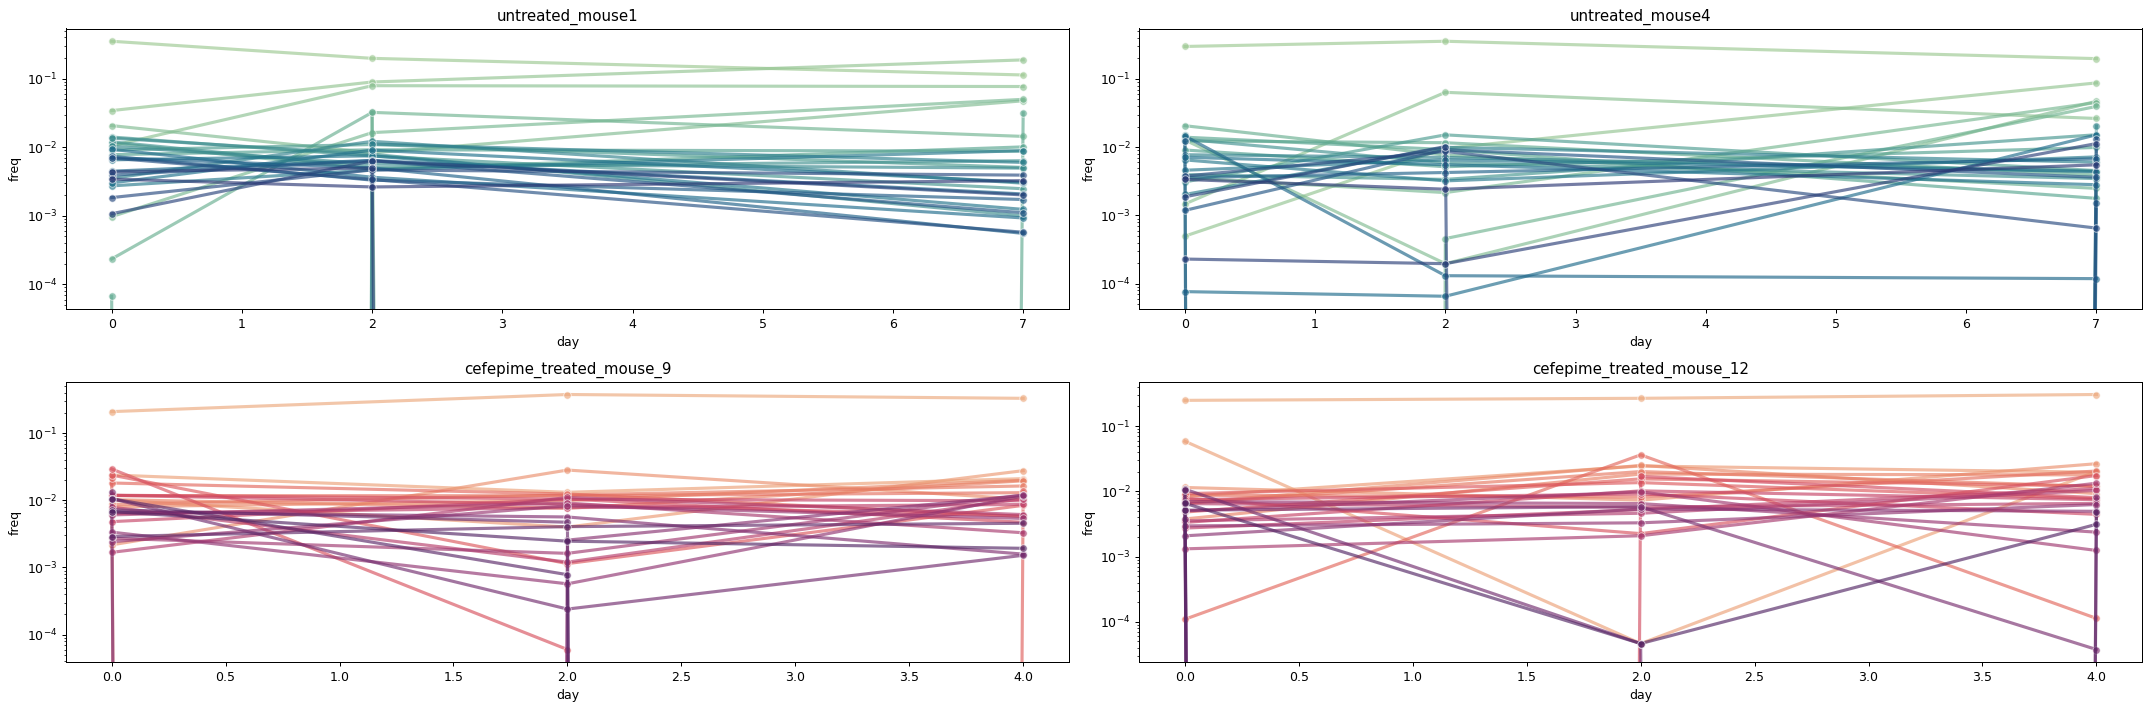

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(24,8), dpi=90)
samples = pd.Series(trajectories.keys())
for unt, ax_index in zip(samples[samples.str.startswith('untreated')].values, list(range(2))):
    ax = axes[0,ax_index]
    sns.lineplot(ax=ax, data=get_freq_plot_table(traj_norm, unt, top=30), x='day', y='freq', hue='barcode', palette="crest", marker='o', linewidth=2.5, alpha=0.65, legend=False)
    ax.set_title(unt)
    ax.set_yscale('log')
for unt, ax_index in zip(samples[samples.str.startswith('cefepime')].values, list(range(2))):
    ax = axes[1,ax_index]
    sns.lineplot(ax=ax, data=get_freq_plot_table(traj_norm, unt, top=30), x='day', y='freq', hue='barcode', palette="flare", marker='o', linewidth=2.5, alpha=0.65, legend=False)
    ax.set_title(unt)
    ax.set_yscale('log')
plt.tight_layout()